Epoch 1/100, Gamma: [1.00540559 0.99357506 0.98645973 0.97546902 1.0242125  0.97442231
 0.9956318  0.98684625 1.01192974 1.01251901 0.97162267 1.00813401
 0.99375494 1.01973375 1.00095801 0.99344965], Beta: [ 0.013689   -0.01385641 -0.0262714  -0.03138154  0.05318064 -0.03776824
 -0.01522238 -0.05817436  0.02837914  0.0188606  -0.06256464  0.01405932
 -0.00983327  0.03609364  0.0049015  -0.01051964]
Epoch 10/100, Train Loss: 0.036548241100580685, Validation Loss: 0.02710477065730259
Epoch 10/100, Gamma: [1.01150613 0.98053763 0.96167026 0.95682333 1.03426303 0.94301013
 0.99581256 1.02065554 1.03357925 1.00981832 0.95490434 1.0096309
 0.98850176 1.03511965 0.99905851 0.97893928], Beta: [ 0.02992317 -0.04833585 -0.06220022 -0.03681488  0.04922517 -0.05309195
 -0.02256039 -0.07877473  0.06622767  0.00492795 -0.09759042  0.02499377
 -0.01958594  0.07959479  0.00622061 -0.03219386]
Epoch 20/100, Train Loss: 0.02715614722111212, Validation Loss: 0.022141009381693715
Epoch 20/100, Gamma: [1.

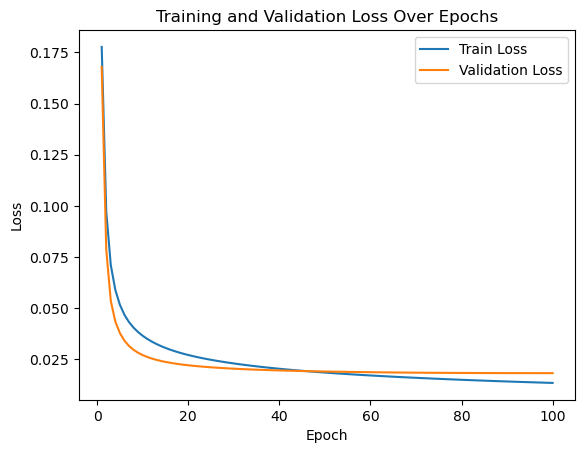

Train Accuracy: 0.9849246231155779
Test Accuracy: 1.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.weights1 = np.random.randn(input_size, hidden_size)
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size)
        self.bias2 = np.zeros((1, output_size))
        
        self.epsilon = 1e-8
        self.losses_train = []
        self.losses_val = []
        
        # Initialize parameters for batch normalization
        self.gamma = np.ones((hidden_size,))
        self.beta = np.zeros((hidden_size,))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def batch_norm_forward(self, x, gamma, beta):
        mean = np.mean(x, axis=0)
        variance = np.var(x, axis=0)
        x_norm = (x - mean) / np.sqrt(variance + self.epsilon)
        out = gamma * x_norm + beta
        return out, x_norm, mean, variance

    def batch_norm_backward(self, dout, x, x_norm, mean, variance):
        N, D = x.shape
        x_mu = x - mean
        std_inv = 1. / np.sqrt(variance + self.epsilon)
        
        dx_norm = dout * self.gamma
        dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * std_inv**3
        dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2. * x_mu, axis=0)

        dx = (dx_norm * std_inv) + (dvar * 2 * x_mu / N) + (dmu / N)
        dgamma = np.sum(dout * x_norm, axis=0)
        dbeta = np.sum(dout, axis=0)

        return dx, dgamma, dbeta

    def forward(self, X):
        self.hidden_output = self.sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.output = self.sigmoid(np.dot(self.hidden_output, self.weights2) + self.bias2)
        return self.output

    def backward(self, X, y, output, learning_rate):
        error = y - output
        delta_output = error * self.sigmoid_derivative(output)
        
        error_hidden = delta_output.dot(self.weights2.T)
        delta_hidden = error_hidden * self.sigmoid_derivative(self.hidden_output)
        
        # Update weights and biases using gradient descent
        dweights2 = self.hidden_output.T.dot(delta_output)
        dbias2 = np.sum(delta_output, axis=0, keepdims=True)
        dweights1 = X.T.dot(delta_hidden)
        dbias1 = np.sum(delta_hidden, axis=0, keepdims=True)
        
        self.weights2 += learning_rate * dweights2
        self.bias2 += learning_rate * dbias2
        self.weights1 += learning_rate * dweights1
        self.bias1 += learning_rate * dbias1
        
        # Batch normalization backward pass
        dhidden_norm, dgamma, dbeta = self.batch_norm_backward(delta_hidden, np.dot(X, self.weights1), self.hidden_output, np.mean(self.hidden_output, axis=0), np.var(self.hidden_output, axis=0))
        
        # Update weights and biases for batch normalization
        self.weights1 += learning_rate * dweights1
        self.bias1 += learning_rate * dbias1
        self.gamma += learning_rate * dgamma
        self.beta += learning_rate * dbeta
        
        return self.gamma, self.beta
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
        for epoch in range(epochs):
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                output = self.forward(X_batch)
                gamma, beta = self.backward(X_batch, y_batch, output, learning_rate)
            
            # Calculate and store the training loss for this epoch
            loss_train = np.mean(np.square(y_train - self.forward(X_train)))
            self.losses_train.append(loss_train)

            # Calculate and store the validation loss for this epoch
            loss_val = np.mean(np.square(y_val - self.forward(X_val)))
            self.losses_val.append(loss_val)

            if (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss_train}, Validation Loss: {loss_val}')
                
            if (epoch+1) == 1 or (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Gamma: {gamma}, Beta: {beta}')

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert labels to one-hot encoding
y_train = np.eye(2)[y_train]
y_val = np.eye(2)[y_val]
y_test = np.eye(2)[y_test]

# Set hyperparameters
input_size = X_train.shape[1]
hidden_size = 16
output_size = 2
learning_rate = 0.01
epochs = 100
batch_size = 32

# Initialize neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the neural network
nn.train(X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate)

# Plot training and validation loss graphs
plt.plot(range(1, epochs+1), nn.losses_train, label='Train Loss')
plt.plot(range(1, epochs+1), nn.losses_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Calculate train and test accuracies
train_predictions = np.argmax(nn.forward(X_train), axis=1)
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), train_predictions)

test_predictions = np.argmax(nn.forward(X_test), axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), test_predictions)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
